In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import calculate_relative_presentation
from grakel import Graph

In [12]:
node_label = 'CellType'
iteration = 5
PhenoGraph_k = 100

In [13]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_0_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ))

Patient_IDs = SoftWL_dict["Patient_id"]

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)


FILE_NAMES = os.listdir(
    os.path.join(
        PROJECT_ROOT,
        "Output",
        "b_Soft_WL_Kernel_random_split",
        "Danenberg",
        "Subset_1",
        "Subtrees",
    )
)
G_list = []
Patient_IDs_with_duplicate = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    node_attributes = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "a_Cellular_graph_random_split",
            "Danenberg",
            "Subset_1",
            file_name,
            node_label + ".npy",
        )
    ).tolist()
    A = np.load(
         os.path.join(
            PROJECT_ROOT,
            "Output",
            "a_Cellular_graph_random_split",
            "Danenberg",
            "Subset_1",
            file_name,
            "Adj.npy",
        )
    )
    np.fill_diagonal(A, 0)
    A[A < 0.001] = 0
    A[A!=0] = 1
    patient_id = int(file_name.split("_")[1])
    node_attributes = {k: v for k, v in enumerate(node_attributes)}
    G = Graph(A, node_labels=node_attributes)
    G_list.append(G)
    Patient_IDs_with_duplicate.append(patient_id)

print(len(Patient_IDs_with_duplicate), len(np.unique(Patient_IDs_with_duplicate)))

from scipy.linalg import block_diag
G_list_combined = []
for patient_id in Patient_IDs:
    indices = np.where((np.array(Patient_IDs_with_duplicate) == patient_id))[0].tolist()
    A_combined = block_diag(
        *[g.get_adjacency_matrix() for g in np.array(G_list)[indices]]
    )
    node_attributes_combined_list = np.concatenate(
        [np.array(list(g.get_labels().values())) for g in np.array(G_list)[indices]]
    ).tolist()
    node_attributes_combined = {
        k: v for k, v in enumerate(node_attributes_combined_list)
    }
    G_combined = Graph(A_combined, node_labels=node_attributes_combined)
    # edge_attributes_combined = {i: 1 for i in G_combined.get_edges()}
    G_combined = Graph(
        A_combined,
        node_labels=node_attributes_combined,
        # edge_labels=edge_attributes_combined,
    )
    G_list_combined.append(G_combined)

from grakel.kernels import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(
        n_iter=iteration, normalize=False, base_graph_kernel=VertexHistogram
    )
Kernel_matrix = kernel.fit_transform(G_list_combined)


404 379


In [14]:
import matplotlib.pyplot as plt
Unique_color_SoftWL = []
Uniue_color_WL = []
SoftWL_dir = "/cis/home/zwang/Projects/Cell-GNN/SoftWL/Danenberg/"
for i in range(1, iteration + 1):
    Uniue_color_WL.append(len(kernel._inv_labels[i]))
    SoftWL_dict = pickle.load(
        open(
            os.path.join(
                PROJECT_ROOT,
                "Output",
                "b_Soft_WL_Kernel",
                "Danenberg",
                "Cohort_1",
                "SoftWL_dict_iter_"
                + str(iteration)
                + "_PhenoGraph_k_"
                + str(PhenoGraph_k)
                + ".pkl",
            ),
            "rb",
        ),
    )
    Histograms = SoftWL_dict["Histogram"]
    Unique_color_SoftWL.append(Histograms.shape[1])

unique_color_0 = 32
Unique_color_SoftWL = [unique_color_0] + Unique_color_SoftWL
Uniue_color_WL = [unique_color_0] + Uniue_color_WL

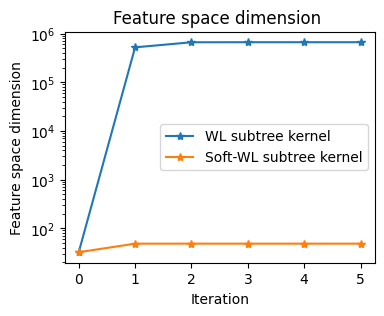

In [16]:
f, ax = plt.subplots(figsize=(4,3))
ax.plot(range(iteration+1), Uniue_color_WL, '-*', label='WL subtree kernel')
ax.plot(range(iteration+1), Unique_color_SoftWL, '-*', label='Soft-WL subtree kernel')
# ax.plot(range(iteration+1), Unique_color_SoftWL_SoftA, '-*', label='SoftWL_SoftA')
ax.set_xlabel('Iteration')
ax.set_ylabel('Feature space dimension')
ax.set_title("Feature space dimension ")
ax.legend()
f.show()
ax.set_yscale("log")
